In [446]:
import os
import pickle
import time
import sys
import numpy as np
import torch

# Model
from symbxai.lrp.symbolic_xai import ViTSymbolicXAI
from symbxai.model.vision_transformer import ModifiedViTForImageClassification

# Dataset
from symbxai.dataset.part_imagenet import PartImageNetDataset
import matplotlib.pylab as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import transformers
import torchvision
import requests
from PIL import Image
from io import BytesIO
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image, scale_cam_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
import cv2
import ast
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib.patches as patches
from symbxai.utils import powerset
import os.path
from functools import reduce 

## Load model

Load the ViT-Base model trained on the ImageNet dataset.

In [447]:
processor = transformers.AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model = transformers.AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")

model.eval()

model.vit.embeddings.patch_embeddings.requires_grad = False
model.vit.embeddings.patch_embeddings.requires_grad = False

for name, param in model.named_parameters():
    if name.endswith('embed'):
        param.requires_grad = False

pretrained_embeddings = model.vit.embeddings

## Load dataset

In [448]:
car_synset_dict = {
    "minivan": "n03770679"
}

car_labels_dict = {
    "n03770679": 656
}

bike_synset_dict = {
    "mountatin bike": "n03792782"
}

bike_labels_dict = {
    "n03792782": 671
}

In [449]:
# Open the text file and read the content
with open("data/imagenet/imagenet_label_to_wordnet_synset.txt", "r") as file:
    data = file.read()

# Convert the string back to a dictionary
dictionary = ast.literal_eval(data)  # Safer than eval()

class_mapping = {}
class_mapping_rev = {}
class_names = {}
class_names_rev = {}
label_mapping = {}
for k, v in dictionary.items():
    class_mapping[v['id'].split('-')[1] + v['id'].split('-')[0]] = k
    class_mapping_rev[k] = v['id'].split('-')[1] + v['id'].split('-')[0]
    class_names[k] = v['label']
    class_names_rev[v['label']] = k
    label_mapping[v['id'].split('-')[1] + v['id'].split('-')[0]] = k


In [450]:
dataset_class = 'mountain bike'

val_set = PartImageNetDataset(
    data_path="data/imagenet/PartImageNet_OOD/",
    mode='train',
    get_masks=True,
    image_size=(224, 224),
    evaluate=True)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [451]:
car_images = val_set.dataset[val_set.dataset['class'].isin(car_synset_dict.values())]
bike_images = val_set.dataset[val_set.dataset['class'].isin(bike_synset_dict.values())]

if dataset_class == 'mountain bike':
    val_set.dataset = bike_images
elif dataset_class == 'minivan':
    val_set.dataset = car_images
else:
    raise NotImplementedError

val_set.dataset

,index,test,label,class,filename
16207,16207,0,93,n03792782,n03792782_14531.JPEG
16211,16211,0,93,n03792782,n03792782_8224.JPEG
16212,16212,0,93,n03792782,n03792782_42182.JPEG
16213,16213,0,93,n03792782,n03792782_26383.JPEG
16214,16214,0,93,n03792782,n03792782_15431.JPEG
...,...,...,...,...,...
16533,16533,0,93,n03792782,n03792782_3334.JPEG
16534,16534,0,93,n03792782,n03792782_17737.JPEG
16536,16536,0,93,n03792782,n03792782_737.JPEG
16537,16537,0,93,n03792782,n03792782_3921.JPEG


### Check a single sample, its segments, and first-order explanation

In [452]:
sample_id = 0
inputs, _, landmarks = val_set.__getitem__(sample_id)

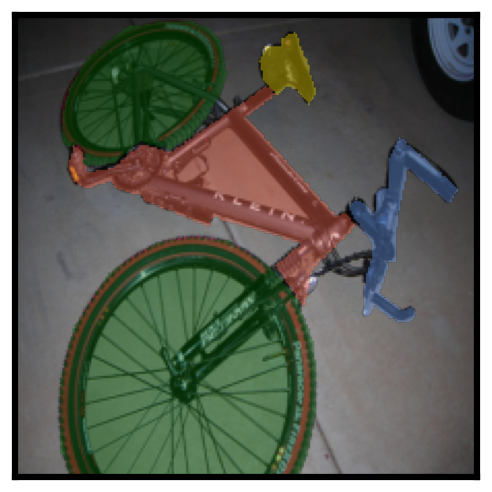

In [453]:
# Assuming inputs and landmarks are already loaded as tensors
# inputs: torch.Tensor of shape [C, H, W] for RGB image
# landmarks: torch.Tensor of shape [40, H, W] for binary masks

# Convert inputs to numpy for plotting (assuming C is 3 for RGB)
image = inputs.permute(1, 2, 0).numpy()  # [H, W, 3]

# Initialize a canvas to store the combined mask overlay (RGBA)
height, width = landmarks.shape[1], landmarks.shape[2]
combined_mask = np.zeros((height, width, 4), dtype=np.uint8)  # RGBA

# Define a list of 40 unique colors for each mask (RGBA format)
unique_colors = [
    (255, 0, 0, 100),    # Red
    (0, 255, 0, 100),    # Green
    (0, 0, 255, 100),    # Blue
    (255, 255, 0, 100),  # Yellow
    (255, 0, 255, 100),  # Magenta
    (0, 255, 255, 100),  # Cyan
    (192, 192, 192, 100), # Silver
    (128, 0, 0, 100),    # Maroon
    (128, 128, 0, 100),  # Olive
    (0, 128, 0, 100),    # Dark Green
    (0, 0, 128, 100),    # Navy
    (128, 0, 128, 100),  # Purple
    (0, 128, 128, 100),  # Teal
    (255, 165, 0, 100),  # Orange
    (255, 20, 147, 100), # Deep Pink
    (75, 0, 130, 100),   # Indigo
    (255, 69, 0, 100),   # Red-Orange
    (173, 216, 230, 100), # Light Blue
    (144, 238, 144, 100), # Light Green
    (255, 228, 196, 100), # Bisque
    (240, 128, 128, 100), # Light Coral
    (128, 128, 128, 100), # Gray
    (128, 255, 0, 100),   # Lime
    (0, 255, 128, 100),   # Spring Green
    (255, 128, 0, 100),   # Orange Red
    (0, 128, 255, 100),   # Sky Blue
    (128, 0, 255, 100),   # Violet
    (255, 99, 71, 100),   # Tomato
    (100, 149, 237, 100), # Cornflower Blue
    (255, 228, 0, 100),   # Bright Yellow
    (0, 100, 0, 100),     # Dark Green
    (238, 130, 238, 100), # Violet
    (255, 160, 122, 100), # Light Salmon
    (219, 112, 147, 100), # Pale Violet Red
    (0, 191, 255, 100),   # Deep Sky Blue
    (85, 107, 47, 100),   # Dark Olive Green
    (240, 255, 240, 100), # Honeydew
    (255, 245, 238, 100), # Seashell
    (240, 248, 255, 100), # Alice Blue
    (255, 215, 0, 100),   # Gold
    (255, 192, 203, 100)  # Pink
]

# Ensure the number of unique colors matches the number of masks
if len(unique_colors) < landmarks.shape[0]:
    raise ValueError(f"Not enough unique colors defined. Need at least {landmarks.shape[0]} colors.")

# Loop through each binary mask in landmarks
for idx in range(landmarks.shape[0]):
    mask = landmarks[idx].numpy()  # Convert tensor to numpy array
    if mask.sum() > 0:  # Check if the mask is non-zero
        rgba_color = unique_colors[idx]  # Use predefined unique color

        # Apply color to the combined mask where the current mask is 1
        combined_mask[mask == 1] = rgba_color  # Color where mask is 1

# Plot the result
fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
plt.setp(axs.spines.values(), lw=3, color='black')
plt.imshow(image)  # Show the original image
plt.imshow(combined_mask)  # Overlay the combined mask
plt.xticks([])
plt.yticks([])
plt.show()

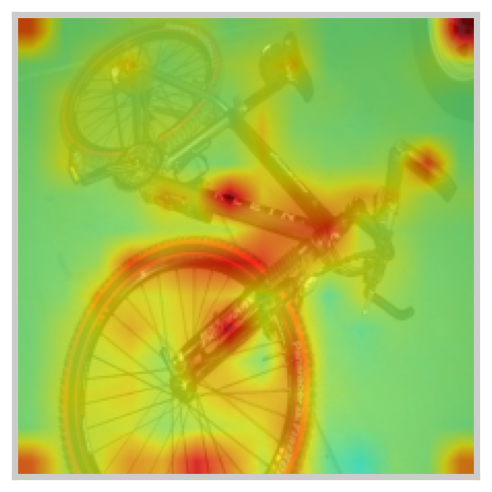

In [454]:
labels = label_mapping[val_set.dataset.iloc[sample_id]['class']]
targets = torch.eye(1000, dtype=inputs.dtype)[labels]

symbxai_vit = ViTSymbolicXAI(
        model=deepcopy(model),
        embeddings=pretrained_embeddings,
        sample=inputs.unsqueeze(0),
        target=targets,
        scal_val=1.,
        use_lrp_layers=True
    )

R = symbxai_vit.node_relevance().detach().numpy()[1:] 

R = R / np.max(np.abs(R))  # Normalize between [-1, 1]# normalize to [-1,1] wrt to max relevance magnitude
fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
plt.setp(axs.spines.values(), lw=3)
plt.imshow(cv2.resize(R.reshape(14, 14), (224, 224)), vmin=-1, vmax=1, cmap='jet')
plt.imshow(inputs.permute(1, 2, 0), alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.show()

## Visualization Utils

In [455]:
def get_masked_patch_ids(image, masks, patch_size, threshold=0.5):
    """
    Returns unique IDs of patches that include parts of the segmentation masks,
    ensuring no overlap between patch IDs for different masks, with a threshold to decide 
    patch assignment when there is overlap.

    Args:
        image (np.array): Original image array.
        masks (list of np.array): List of binary mask arrays, each with the same height and width as the image.
        patch_size (tuple): Size of each patch (height, width).
        threshold (float): The threshold for overlap to decide which mask a patch belongs to (0 < threshold <= 1).

    Returns:
        dict: Dictionary where keys are mask indices and values are lists of unique patch IDs for that mask.
    """
    # Get image dimensions
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_size
    
    # Calculate the total number of patches along each dimension
    num_patches_y = (img_height + patch_height - 1) // patch_height
    num_patches_x = (img_width + patch_width - 1) // patch_width
    
    # Initialize dictionary to store patch IDs for each mask
    masked_patch_ids = {i: [] for i in range(len(masks))}
    
    # Loop over the image in steps of the patch size
    for i in range(0, img_height, patch_height):
        for j in range(0, img_width, patch_width):
            # Calculate the current patch ID
            patch_id = (i // patch_height) * num_patches_x + (j // patch_width)
            
            # Extract the current patch from each mask
            patch_area = slice(i, i + patch_height), slice(j, j + patch_width)
            patch_areas = [mask[patch_area] for mask in masks]
            
            # Compute the overlap for each mask in the current patch
            patch_overlap = []
            for k, mask_patch in enumerate(patch_areas):
                # Count the number of pixels in the patch and the number of masked pixels
                patch_pixels = mask_patch.size
                masked_pixels = np.sum(mask_patch)
                
                # Calculate the overlap ratio
                overlap_ratio = masked_pixels / patch_pixels
                patch_overlap.append((k, overlap_ratio))
            
            # Sort patch overlaps in descending order based on overlap ratio
            patch_overlap.sort(key=lambda x: x[1], reverse=True)
            
            # If the highest overlap ratio is above the threshold, assign the patch to the corresponding mask
            if patch_overlap[0][1] >= threshold:
                # Add the patch ID to the appropriate mask's list
                mask_index = patch_overlap[0][0]
                masked_patch_ids[mask_index].append(patch_id)
            else:
                # If no overlap meets the threshold, find the first mask with valid overlap (no overlap)
                for k, mask_patch in enumerate(patch_areas):
                    if np.any(mask_patch):  # If any part of the mask exists in the patch
                        mask_index = k
                        masked_patch_ids[mask_index].append(patch_id)
                        break
    
    return list(masked_patch_ids.values())


# ----------------------
# Use for car classes
# ----------------------
def get_masked_patch_ids_for_multiple_masks(image, masks, patch_size, threshold=0.5):
    """
    Returns unique IDs of patches that include parts of the segmentation masks,
    ensuring no overlap between patch IDs for different masks, with a threshold to decide 
    patch assignment when there is overlap. If a patch overlaps with patches assigned to 
    mask 3 and mask 1, it is assigned to mask 1. Patches that do not overlap with any mask
    above the threshold will not be assigned to any mask.

    Args:
        image (np.array): Original image array.
        masks (list of np.array): List of binary mask arrays, each with the same height and width as the image.
        patch_size (tuple): Size of each patch (height, width).
        threshold (float): The threshold for overlap to decide which mask a patch belongs to (0 < threshold <= 1).

    Returns:
        dict: Dictionary where keys are mask indices and values are lists of unique patch IDs for that mask.
    """
    # Get image dimensions
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_size
    
    # Calculate the total number of patches along each dimension
    num_patches_y = (img_height + patch_height - 1) // patch_height
    num_patches_x = (img_width + patch_width - 1) // patch_width
    
    # Initialize dictionary to store patch IDs for each mask
    masked_patch_ids = {i: [] for i in range(len(masks))}
    mask_patch_counts = {i: 0 for i in range(len(masks))}  # Keep track of how many patches each mask has

    # Loop over the image in steps of the patch size
    for i in range(0, img_height, patch_height):
        for j in range(0, img_width, patch_width):
            # Calculate the current patch ID
            patch_id = (i // patch_height) * num_patches_x + (j // patch_width)
            
            # Extract the current patch from each mask
            patch_area = slice(i, i + patch_height), slice(j, j + patch_width)
            patch_areas = [mask[patch_area] for mask in masks]
            
            # Compute the overlap for each mask in the current patch
            patch_overlap = []
            for k, mask_patch in enumerate(patch_areas):
                # Count the number of pixels in the patch and the number of masked pixels
                patch_pixels = mask_patch.size
                masked_pixels = np.sum(mask_patch)
                
                # Calculate the overlap ratio
                overlap_ratio = masked_pixels / patch_pixels
                patch_overlap.append((k, overlap_ratio))
            
            # Sort patch overlaps in descending order based on overlap ratio
            patch_overlap.sort(key=lambda x: x[1], reverse=True)

            # Check if there's overlap with mask 3 and mask 1, and enforce assigning to mask 1
            mask1_assigned = False
            mask3_assigned = False
            mask2_assigned = False
            for mask_index, overlap_ratio in patch_overlap:
                if mask_index == 0 and overlap_ratio >= threshold:
                    mask1_assigned = True
                elif mask_index == 1 and overlap_ratio >= threshold:
                    mask2_assigned = True
                elif mask_index == 2 and overlap_ratio >= threshold:
                    mask3_assigned = True

            # If patch overlaps with both mask 1 and mask 3, assign it to mask 1
            if mask3_assigned and mask1_assigned:
                mask_index = 2
            elif mask2_assigned and mask1_assigned:
                mask_index = 1
            elif patch_overlap[0][1] >= threshold:
                # Assign to the mask with the highest overlap ratio if no special condition applies
                mask_index = patch_overlap[0][0]
            else:
                # If no overlap meets the threshold, skip the patch (do not assign it to any mask)
                continue
            
            # Add the patch ID to the appropriate mask's list and update the patch count
            masked_patch_ids[mask_index].append(patch_id)
            mask_patch_counts[mask_index] += 1

    return list(masked_patch_ids.values())


def color_masked_patches(image, masks, patch_size):
    """
    Colors the patches containing each mask on a copy of the original image.

    Args:
        image (np.array): Original image array.
        masks (List[np.array]): List of binary mask arrays, one per mask.
        patch_size (tuple): Size of each patch (height, width).
    
    Returns:
        np.array: Image with colored rectangles for each mask.
    """
    # Create a color map for each mask
    colors = plt.cm.get_cmap("jet", len(masks))
    
    # Plot the original image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_size

    ids = get_masked_patch_ids(image, masks, patch_size, threshold=0.1)

    for j, masked_patch_ids in enumerate(ids):
        masked_patch_ids = list(masked_patch_ids)
        for patch_id in masked_patch_ids:
            # Calculate row and column from patch_id
            row = (patch_id * patch_height) // img_width
            col = (patch_id % (img_width // patch_width)) * patch_width
            
            # Draw a rectangle at the patch location
            rect = patches.Rectangle(
                (col, row * patch_height), patch_width, patch_height, linewidth=1,
                edgecolor=colors(j)[:3], facecolor=colors(j)[:3], alpha=0.4
            )
            ax.add_patch(rect)
    
    plt.axis("off")
    plt.show()

#### Check segmentation masks

27


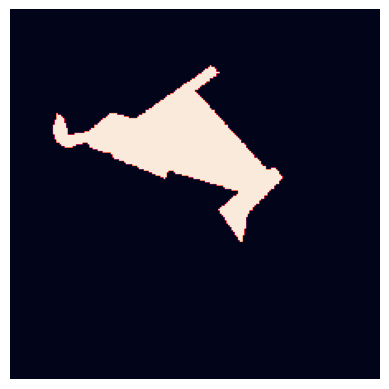

28


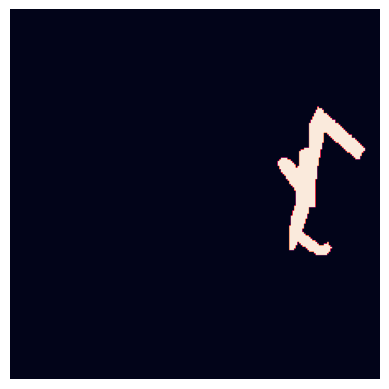

29


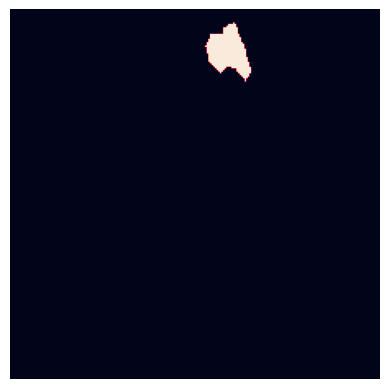

30


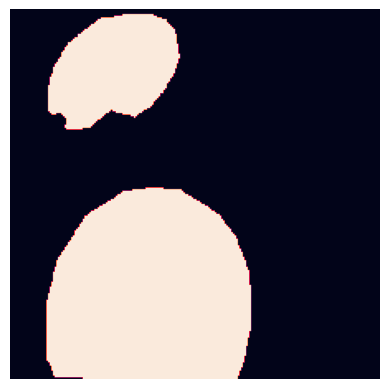

In [456]:
masks = []
patches_ids = []
for idx in range(landmarks.shape[0]):
    if landmarks[idx].sum() > 0:
        masks.append(landmarks[idx].numpy().astype(np.bool_))
        print(idx)
        plt.imshow(landmarks[idx])
        plt.axis('off')
        plt.show()

#### Visualize patches assigned to each segment

/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_27169/2036246371.py:167: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("jet", len(masks))


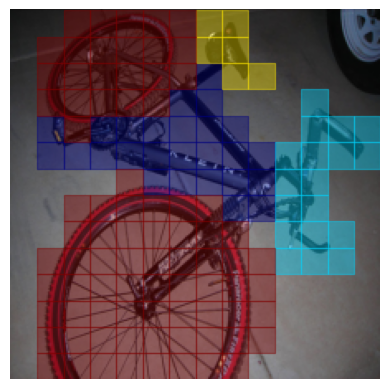

In [457]:
color_masked_patches(image, masks, (16, 16))

## Multi-order terms

### Multi-order terms for individual images

We first look into multi-order terms for indvidual images of the `minivan` or `mountatin bike` classes.

Segments:
- B: body
- T: tier
- S: seat
- H: head
- M: mirror

In [458]:
bike_part_dict = {27: 'body', 28: 'head', 29: 'seat', 30: 'tier'}
car_part_dict = {24: 'body', 25: 'tier', 26: 'mirror'}

In [459]:
if dataset_class == 'minivan':
    all_rels = {'B':[], 'T':[], 'M':[]}
elif dataset_class == 'mountain bike':
    all_rels = {'B':[], 'T':[], 'H':[], 'S':[]}
else:
    raise NotImplementedError
    
# sample_id = 0
inputs, _, landmarks = val_set.__getitem__(sample_id)
label = label_mapping[val_set.dataset.iloc[sample_id]['class']]
if inputs != None:  # check if image is loaded correctly.
    image = inputs.permute(1, 2, 0).numpy()
    logits = model(inputs.unsqueeze(0)).logits
    prediction = logits.argmax()

    if prediction.item() == label:  # check if image is correctly classified.

        # create explainer
        targets = torch.eye(1000, dtype=inputs.dtype)[label]
        explainer = ViTSymbolicXAI(
            model=deepcopy(model),
            embeddings=pretrained_embeddings,
            sample=inputs.unsqueeze(0),
            target=targets,
            scal_val=1.,
            use_lrp_layers=True
        )

        # assign patches to each segment
        masks = {}
        patches_ids = []
        substructures = {}
        for idx in range(landmarks.shape[0]):
            if landmarks[idx].sum() > 0:
                masks[idx] = landmarks[idx].numpy().astype(np.bool_)

        if dataset_class == 'minivan':
            patches_ids = get_masked_patch_ids_for_multiple_masks(image, list(masks.values()), (16, 16), threshold=0.1)
            for i, k in enumerate(masks.keys()):
                substructures[car_part_dict[k]] = patches_ids[i]
            
        elif dataset_class == 'mountain bike': 
            patches_ids = get_masked_patch_ids(image, list(masks.values()), (16, 16), threshold=0.1)
            for i, k in enumerate(masks.keys()):
                substructures[bike_part_dict[k]] = patches_ids[i]

        else:
            raise NotImplementedError
    
        substr_pset = powerset(substructures.keys())

        for j, subst_names in enumerate(substr_pset):
            curr_substrs = [substructures[name] for name in subst_names]
            rel = explainer.harsanyi_div(curr_substrs)

            reduc_name = reduce(lambda x,y: x + '-' + y, [name[0].capitalize() for name in subst_names])
        
            if reduc_name in all_rels.keys():
                all_rels[reduc_name] += [rel.item()]
            else:
                all_rels[reduc_name] = [rel.item()]

#### Visualize the multi-order terms

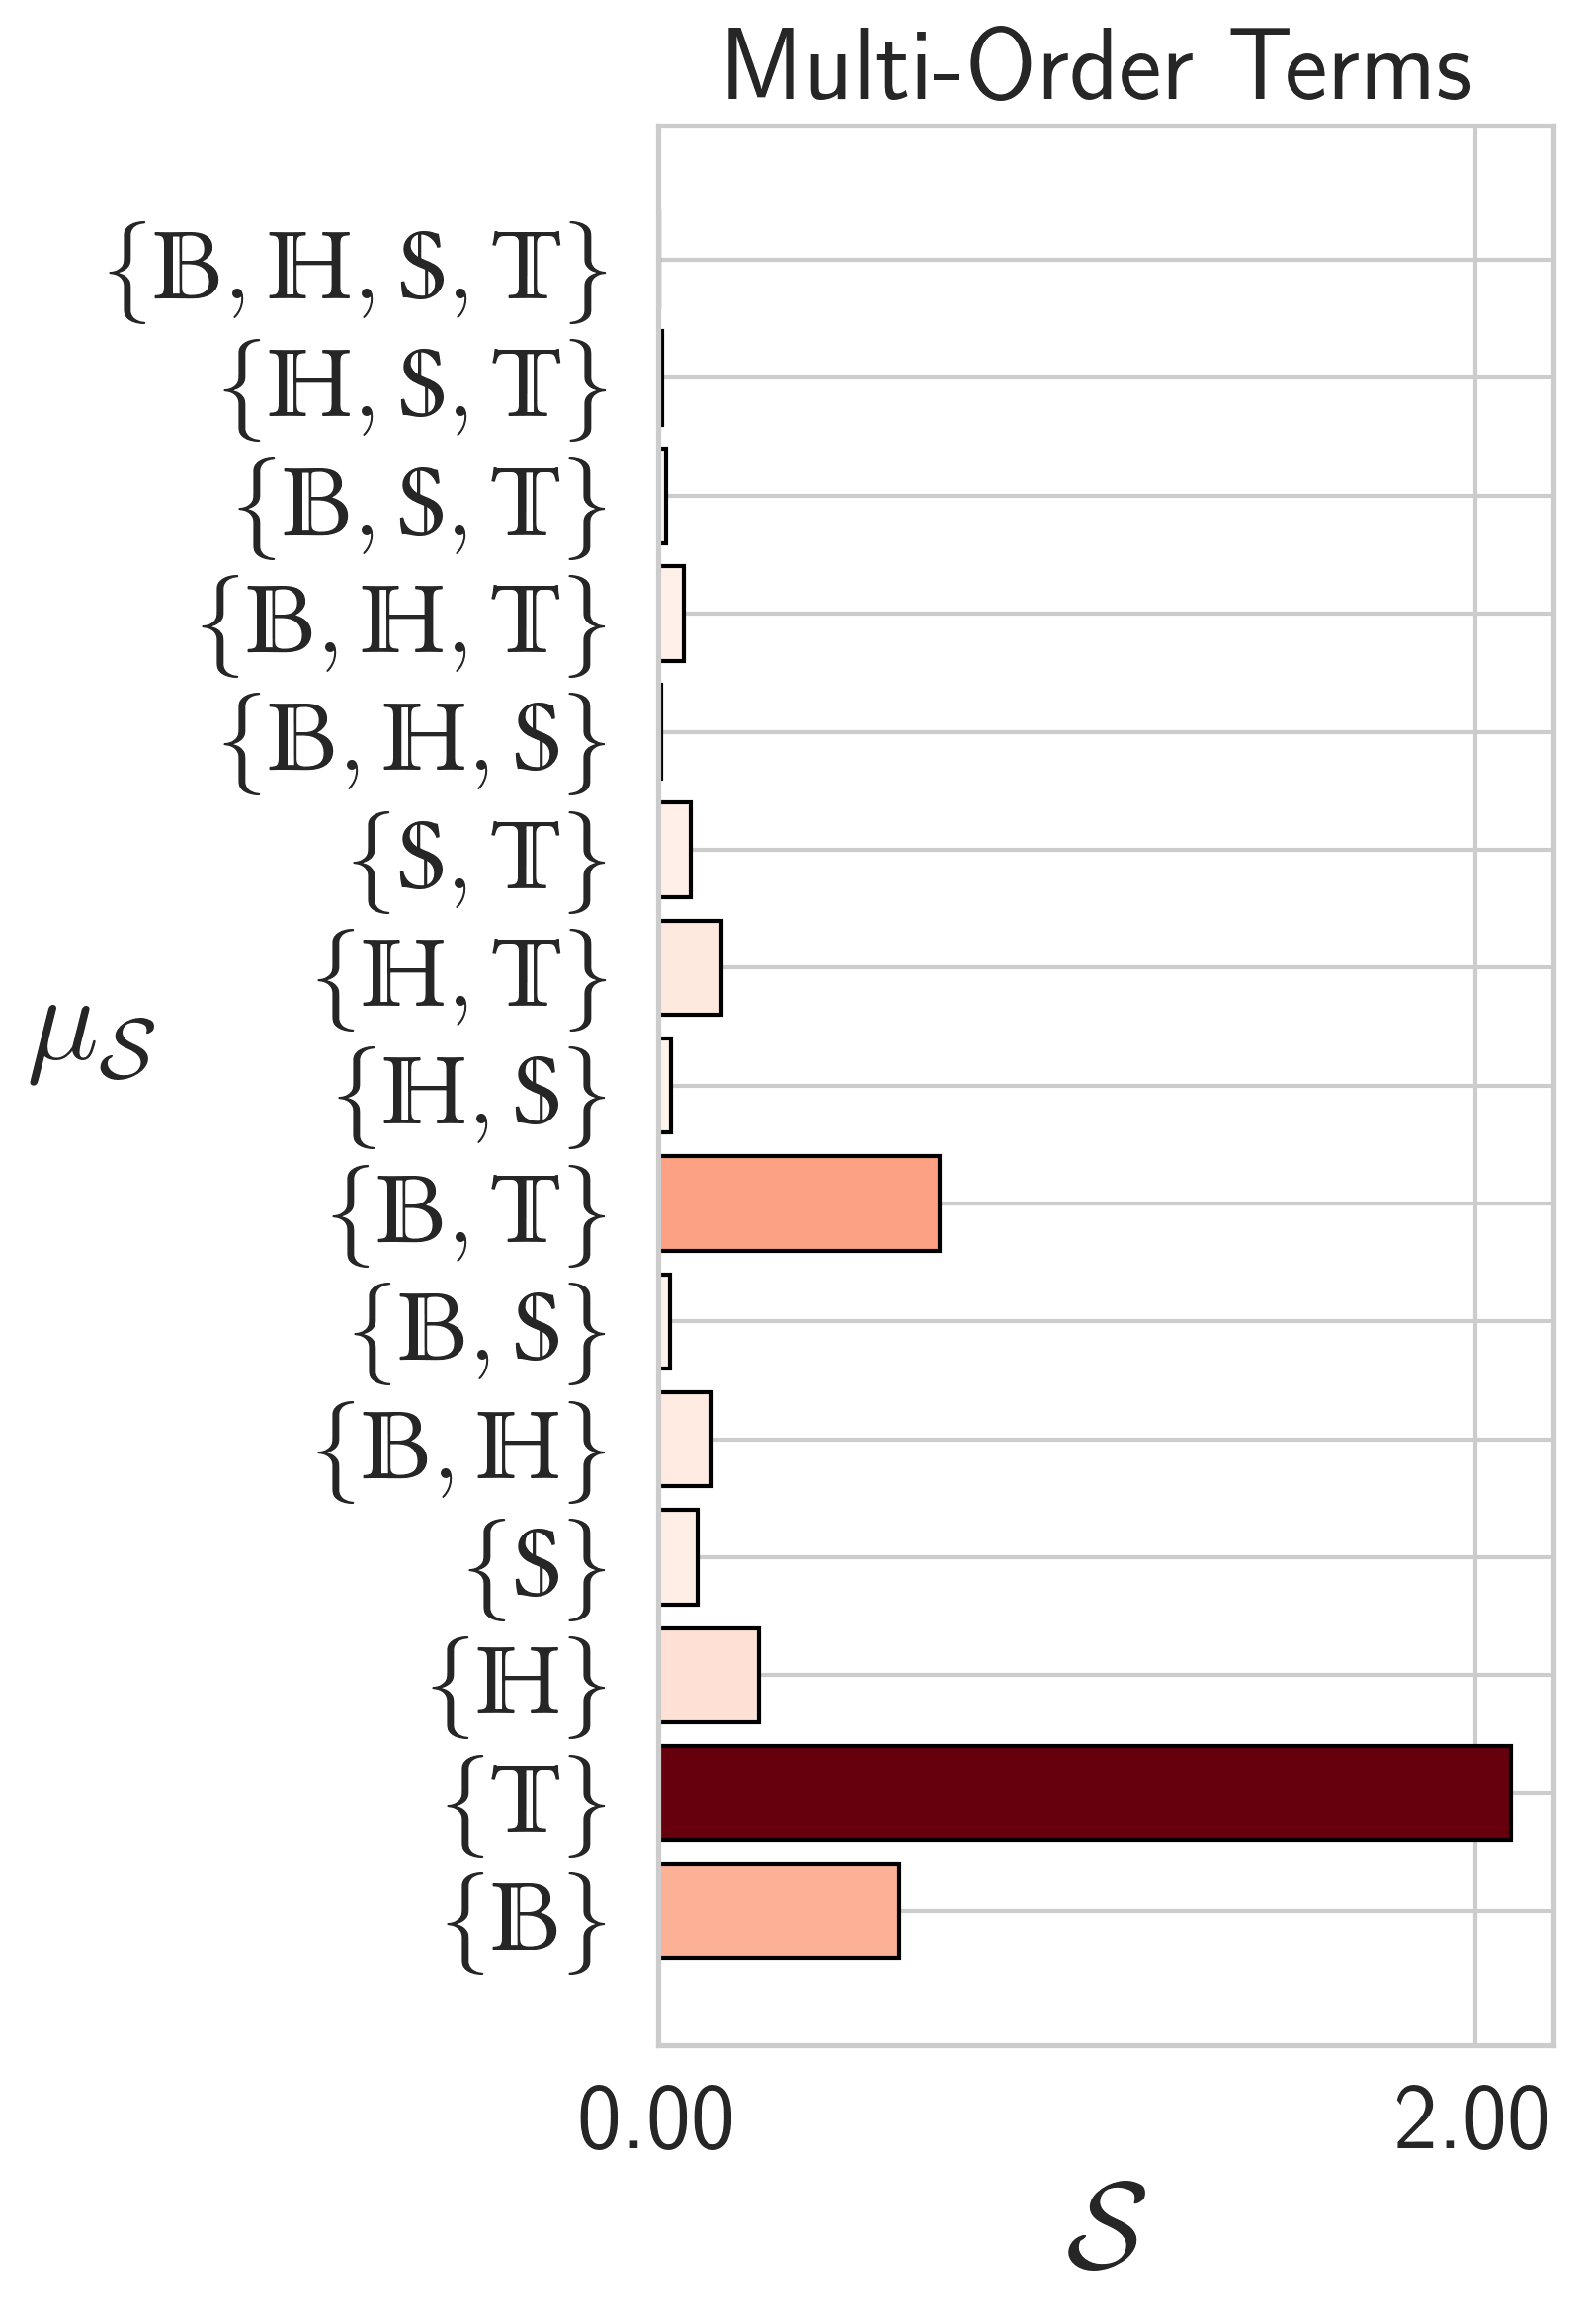

In [460]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc

# Enable LaTeX in Matplotlib
rc('text', usetex=True)

# Add the LaTeX package and configuration to the preamble
rc('text.latex', preamble=r"""
    \usepackage[bb=libus]{mathalpha}
""")
#plt.rcParams['pgf.preamble'] = r'\usepackage{amssymb}\usepackage{amsfonts}' 
#plt.rcParams['pgf.texsystem'] = 'pdflatex'

new_rels = {}
for k, v in all_rels.items():
    if v != []:
        new_rels[k] = v
        
values = np.array(list(new_rels.values())).flatten()
keys = list(new_rels.keys())

new_keys = []
for k in keys:
    splited = k.split('-')
    if len(splited) > 1:
        new_keys.append('$\\mathbb{\{'+','.join(splited)+'\}}$')
    else:
        new_keys.append('$\\mathbb{\{'+ str(splited[0]) +'\}}$')


# Set a high-quality style and figure size
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(5.5, 8), dpi=300)

# Create the bar plot
# Normalize the values for colormap
norm = plt.Normalize(min(values), max(values))
bar_colors = plt.cm.Reds(norm(values))  # Use Reds colormap
bars = plt.barh(new_keys, values, color=bar_colors, edgecolor='black')

# Add labels and title with larger font sizes
plt.xlabel('$\\mathcal{S}$', fontsize=30)
plt.ylabel('$\\mathcal{\\mu}_{\\mathcal{S}}$', fontsize=30, rotation=360)
plt.title('Multi-Order Terms', fontsize=25)

# Adjust tick parameters for better readability
plt.xticks(
    ticks=np.linspace(0, int(np.round(max(values))), 2),  # Limit to 3 ticks: start, midpoint, end
    labels=[f'{val:.2f}' for val in np.linspace(0, int(np.round(max(values))), 2)],  # Format tick labels
    fontsize=23
)
plt.xticks(fontsize=23)
plt.yticks(fontsize=25)

# Add a colorbar for reference
from matplotlib.cm import ScalarMappable  # Import ScalarMappable
sm = ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])  # Dummy array for the colorbar
# cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')  # Associate with current axis
# cbar.set_label('$\\mathcal{\\mu}_{\\mathcal{S}}$', fontsize=20)
# Save the figure as a high-quality file
plt.tight_layout()  # Ensure everything fits within the figure
# plt.savefig("../figures/bar_plot_high_quality.pdf", format='pdf')  # Save as PDF
plt.savefig(f"../pics/bar_plot_bike{sample_id}_horizontal.svg", format='svg', dpi=300, transparent=True)  # Save as PNG

# Show the plot
plt.show()

## Query search

In [461]:
from symbxai.utils import Query_from_promt
from functools import reduce
from copy import copy, deepcopy
import re
from symbxai.query_search.utils import generate_promts

In [462]:
def rowwise_correlation(matrix_a, vector_b, epsilon=1e-8):
    """
    Calculate the Pearson correlation between each row of matrix_a and the vector_b.
    
    Parameters:
    - matrix_a: np.ndarray, shape (n_samples, n_features)
      The matrix whose rows will be correlated with vector_b.
    - vector_b: np.ndarray, shape (1, n_features) or (n_features,)
      The vector to compute the correlation with each row of matrix_a.
    - epsilon: float
      Small value added to standard deviations to prevent division by zero.
      
    Returns:
    - correlations: np.ndarray, shape (n_samples,)
      A vector of correlation coefficients, one for each row of matrix_a.
    """
    # Ensure vector_b is a 1D array
    vector_b = vector_b.ravel()

    # Standardize vector_b
    vector_b_mean = np.mean(vector_b)
    vector_b_std = np.std(vector_b) + epsilon
    vector_b_standardized = (vector_b - vector_b_mean) / vector_b_std
    
    # Standardize matrix_a row-wise
    matrix_a_mean = np.mean(matrix_a, axis=1, keepdims=True)
    matrix_a_std = np.std(matrix_a, axis=1, keepdims=True) + epsilon
    matrix_a_standardized = (matrix_a - matrix_a_mean) / matrix_a_std

    # Compute row-wise correlations
    correlations = np.dot(matrix_a_standardized, vector_b_standardized) / matrix_a.shape[1]
    
    return correlations

In [463]:
import numpy as np
from symbxai.query_search.utils import corr 
from statistics import median
import itertools

if dataset_class == 'minivan':
    all_rels = {'B':[], 'T':[], 'M':[]}
elif dataset_class == 'mountain bike':
    all_rels = {'B':[], 'T':[], 'H':[], 'S':[]}
else:
    raise NotImplementedError

n_queries = (2 ** len(all_rels.keys())) - 1
print(f'we analyse {n_queries} queries.')

query_attributions = {'all': []}
filter_vectors = {}
multi_order_vectors = {}
nb_max_queries = n_queries
result_mode =  'Similarity' #  'Similarity or Relevance' 

for i in tqdm(range(1)):
    inputs, _, landmarks = val_set.__getitem__(i)
    label = label_mapping[val_set.dataset.iloc[i]['class']]
    
    if inputs != None:
        image = inputs.permute(1, 2, 0).numpy()
        
        logits = model(inputs.unsqueeze(0)).logits
        prediction = logits.argmax()

        if prediction.item() == label:
            targets = torch.eye(1000, dtype=inputs.dtype)[label]
            explainer = ViTSymbolicXAI(
                    model=deepcopy(model),
                    embeddings=pretrained_embeddings,
                    sample=inputs.unsqueeze(0),
                    target=targets,
                    scal_val=1.,
                    use_lrp_layers=True
                )
                
            # assign patches to each segment
            masks = {}
            patches_ids = []
            substructures = {}
            for idx in range(landmarks.shape[0]):
                if landmarks[idx].sum() > 0:
                    masks[idx] = landmarks[idx].numpy().astype(np.bool_)
    
            if dataset_class == 'minivan':
                patches_ids = get_masked_patch_ids_for_multiple_masks(image, list(masks.values()), (16, 16), threshold=0.1)
                for i, k in enumerate(masks.keys()):
                    substructures[car_part_dict[k]] = patches_ids[i]
                
            elif dataset_class == 'mountain bike': 
                patches_ids = get_masked_patch_ids(image, list(masks.values()), (16, 16), threshold=0.1)
                for i, k in enumerate(masks.keys()):
                    substructures[bike_part_dict[k]] = patches_ids[i]
    
            else:
                raise NotImplementedError

            if len(patches_ids) == 4:
                substr_pset = powerset(substructures.values())
                multi_order_vector = [explainer.harsanyi_div(subsets) for subsets in substr_pset]
            
            
                n = len(multi_order_vector)
                binary_vectors = list(itertools.product([0, 1], repeat=n))
                filter_vectors = np.array(binary_vectors)
            
                if result_mode == 'Relevance':
                    query_attributions['all'] += [np.dot(filter_vectors, np.array(multi_order_vector).reshape(len(multi_order_vector), 1))]
                    plot_color = (0.5, 0.0, 0.5) 
                    xticks=[-30, -20]
                elif result_mode == 'Similarity':
                    query_attributions['all'] += [rowwise_correlation(filter_vectors, np.array(multi_order_vector).reshape(len(multi_order_vector), 1))]
                    plot_color = (0.8, .6, 0.2)
                    xticks = [-.5,-1]
                else:
                    raise ValueError(f'result_mode = {result_mode} is not a valid input.')

we analyse 15 queries.


100%|██████████| 1/1 [00:08<00:00,  8.68s/it]


In [464]:
import pandas as pd
import json

# process data
staructures_inv = {}
for k, v in substructures.items():
    staructures_inv[str(v)] = k

subs= []
for sub in substr_pset:
    strs = []
    for st in sub:
        strs.append(staructures_inv[str(st)])
        
    subs.append('-'.join(strs))
print(subs)

data = dict(zip(subs, filter_vectors.T))
data['relevance'] = list(np.array(query_attributions['all']).T)
df = pd.DataFrame(data)

# save data
with open("../bike_qs.json", "w") as file:
    df.to_json(file, orient='columns')

['body', 'head', 'seat', 'tier', 'body-head', 'body-seat', 'body-tier', 'head-seat', 'head-tier', 'seat-tier', 'body-head-seat', 'body-head-tier', 'body-seat-tier', 'head-seat-tier', 'body-head-seat-tier']


In [465]:
# Load from the JSON file
with open("../bike_qs.json", "r") as file:
    loaded_data = pd.read_json(file, orient='columns')

top5_idx = np.median(np.array(list(loaded_data['relevance'].values)), axis=1).argsort()[::-1][:5]
for i in top5_idx:
    print(filter_vectors[i])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
[1 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 1 0 0 1 0 0 0 0 0 0 0 0]


#### Top-5 queries:

In [466]:
q_ids, counts = np.unique(np.array(list(loaded_data['relevance'].values)).argsort(axis=0)[::-1][:5], return_counts=True)
top5_idx = q_ids[counts.argsort()[::-1][:5]]
nums = (counts[counts.argsort()[::-1][:5]] / 56) * 100
top5 = dict(zip(subs, filter_vectors[top5_idx].T))
top5['frequency'] = list(nums)

pd.DataFrame(top5)

,body,head,seat,tier,body-head,body-seat,body-tier,head-seat,head-tier,seat-tier,body-head-seat,body-head-tier,body-seat-tier,head-seat-tier,body-head-seat-tier,frequency
0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1.785714
1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1.785714
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.785714
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1.785714
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.785714
